# Adaptive Importance Sampling for Monte Carlo Integration

This notebook provides our implementation of Uniform Sampling, Importance Sampling, and Adaptive Importance Sampling for a series of toy examples. We present comparisons in time to convergence and accuracy. Finally, we present an implementation of a new method for better adaptation of proposals for multimodal target distributions.

### import modules

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

### function definition

Take some function f(x)

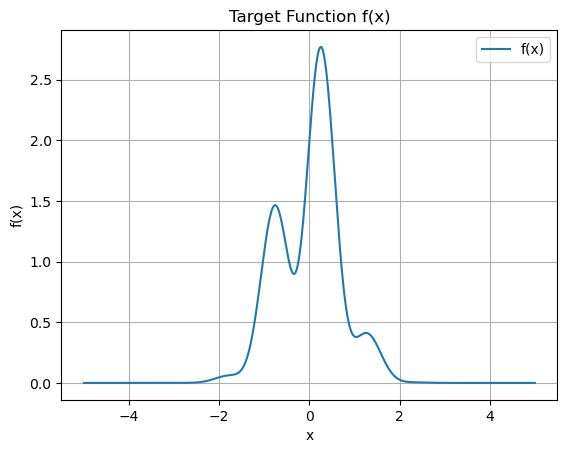

In [6]:
def f(x):
    return np.exp(-x**2) * (2 + np.sin(5 * x))

x = np.linspace(-5, 5, 1000)
plt.plot(x, f(x), label="f(x)")
plt.title("Target Function f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

### uniform sampling

In [7]:
n_samples = 10000
x_samples = np.random.uniform(-5, 5, n_samples)
volume = 10  # width of [-5, 5]

mc_estimate = volume * np.mean(f(x_samples))
print(f"Monte Carlo estimate (uniform): {mc_estimate:.4f}")

Monte Carlo estimate (uniform): 3.5654


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/bb/8wxps2kn7_q58fmzz41mytyc0000gn/T/ipykernel_35686/3792960745.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Uniform Sampling on $f(x) = e^{-x^2}(2 + \sin(5x))$")


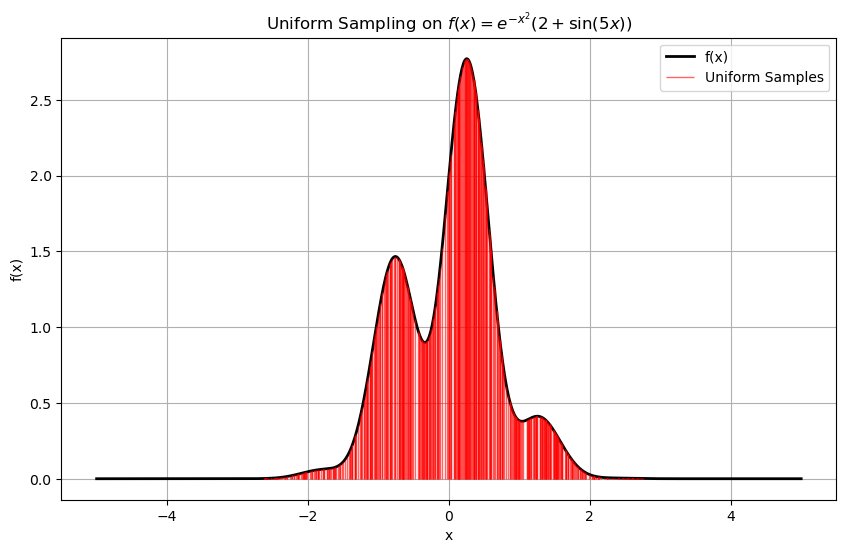

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return np.exp(-x**2) * (2 + np.sin(5 * x))

# Domain
x_vals = np.linspace(-5, 5, 1000)
f_vals = f(x_vals)

# Uniform samples
n_samples = 1000
x_samples = np.random.uniform(-5, 5, n_samples)
y_samples = f(x_samples)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, f_vals, label='f(x)', color='black', lw=2)
plt.vlines(x_samples, 0, y_samples, color='red', alpha=0.6, label='Uniform Samples', linewidth=1)
plt.title("Uniform Sampling on $f(x) = e^{-x^2}(2 + \sin(5x))$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

### importance sampling

In [9]:
# Importance distribution: Gaussian centered at 0, std=1.5
proposal = norm(loc=0, scale=1.5)

x_samples = proposal.rvs(n_samples)
weights = f(x_samples) / proposal.pdf(x_samples)

is_estimate = np.mean(weights)
print(f"Importance sampling estimate: {is_estimate:.4f}")

Importance sampling estimate: 3.3890


#### trying to visualize what's going on

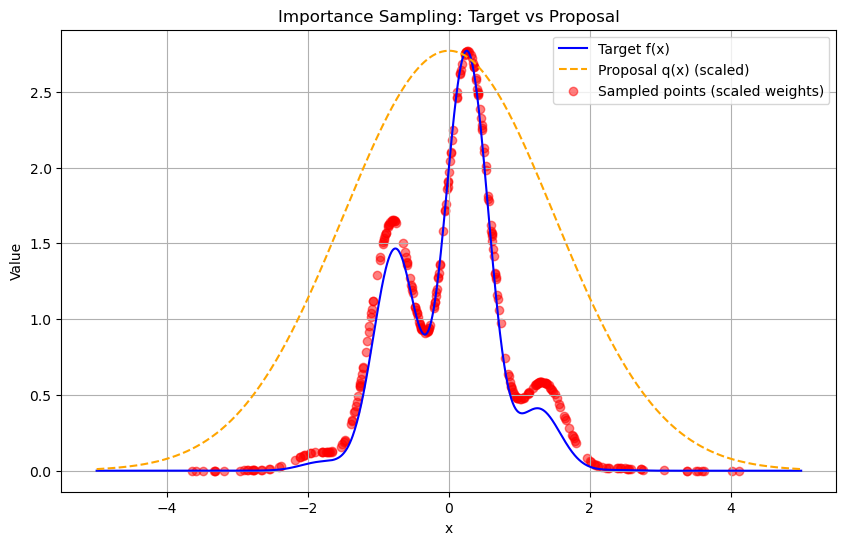

In [10]:
plt.figure(figsize=(10, 6))
x_plot = np.linspace(-5, 5, 1000)
plt.plot(x_plot, f(x_plot), label='Target f(x)', color='blue')
plt.plot(x_plot, proposal.pdf(x_plot) * np.max(f(x_plot)) / np.max(proposal.pdf(x_plot)),
         label='Proposal q(x) (scaled)', linestyle='--', color='orange')

sample_indices = np.random.choice(len(x_samples), size=300, replace=False)
plt.scatter(x_samples[sample_indices], 
            weights[sample_indices] / np.max(weights) * np.max(f(x_plot)), 
            c='red', alpha=0.5, label='Sampled points (scaled weights)')

plt.title("Importance Sampling: Target vs Proposal")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

### adaptive importance sampling

In [11]:
for i in range(3):  # 3 adaptive rounds
    x_samples = proposal.rvs(n_samples) # sample that bad boy. these are our GUESSES for where f is large.
    weights = f(x_samples) / proposal.pdf(x_samples) # WEIGHT it by how important it is. now you're trying to downsample by the pdf weight to REnormalize.
    
    estimate = np.mean(weights)
    print(f"Adaptive round {i+1}, estimate: {estimate:.4f}")

    # defining a new Gaussian; new mean, new std dev
    mean_new = np.average(x_samples, weights=weights)
    std_new = np.sqrt(np.average((x_samples - mean_new)**2, weights=weights))
    
    proposal = norm(loc=mean_new, scale=std_new)

Adaptive round 1, estimate: 3.4572
Adaptive round 2, estimate: 3.5360
Adaptive round 3, estimate: 3.4904


#### trying to visualize what's going on

Adaptive round 1, estimate: 3.4657
Adaptive round 2, estimate: 3.5107
Adaptive round 3, estimate: 3.4986


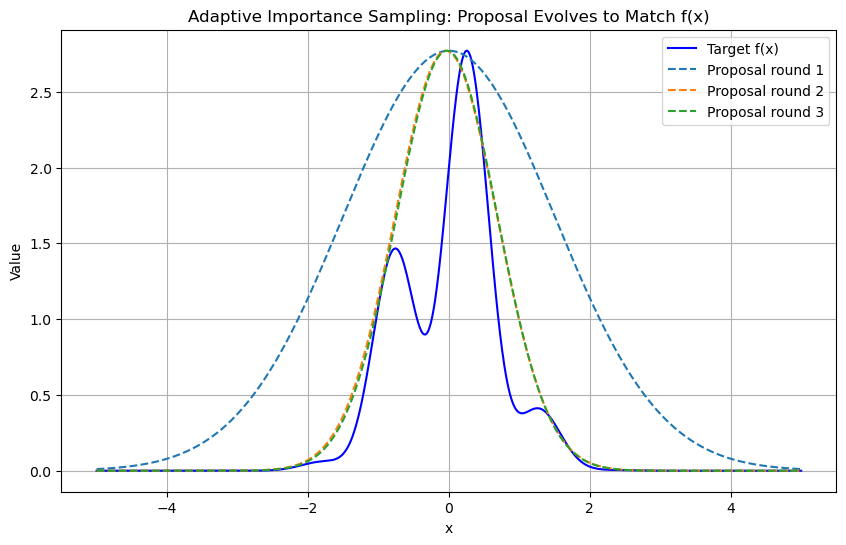

In [12]:
# Store history of proposals
proposal_history = []

proposal = norm(loc=0, scale=1.5)

for i in range(3):
    x_samples = proposal.rvs(n_samples)
    weights = f(x_samples) / proposal.pdf(x_samples)
    estimate = np.mean(weights)
    print(f"Adaptive round {i+1}, estimate: {estimate:.4f}")
    
    proposal_history.append((proposal.mean(), proposal.std()))
    
    mean_new = np.average(x_samples, weights=weights)
    std_new = np.sqrt(np.average((x_samples - mean_new)**2, weights=weights))
    proposal = norm(loc=mean_new, scale=std_new)

x_plot = np.linspace(-5, 5, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x_plot, f(x_plot), label='Target f(x)', color='blue')

for i, (mu, sigma) in enumerate(proposal_history):
    pdf_vals = norm(loc=mu, scale=sigma).pdf(x_plot)
    scaled_pdf = pdf_vals * np.max(f(x_plot)) / np.max(pdf_vals)
    plt.plot(x_plot, scaled_pdf, label=f'Proposal round {i+1}', linestyle='--')

plt.title("Adaptive Importance Sampling: Proposal Evolves to Match f(x)")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

### Comparison of methods

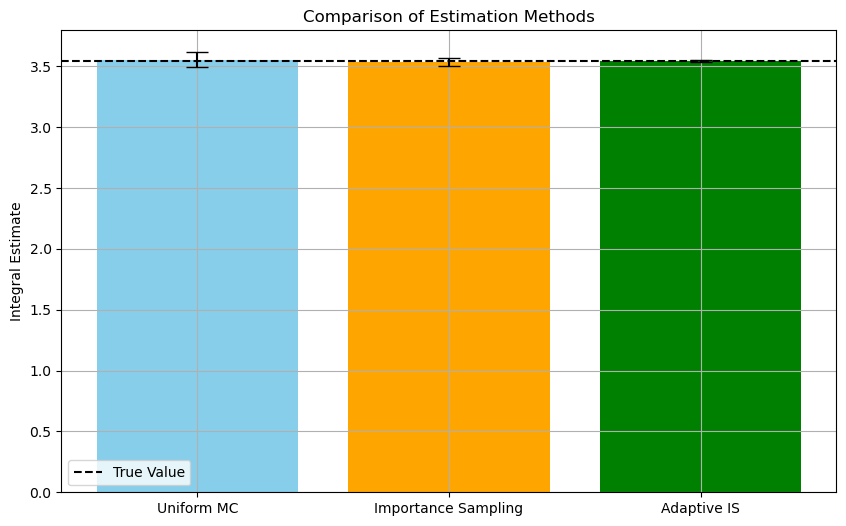

In [13]:
def f(x):
    return np.exp(-x**2) * (2 + np.sin(5 * x))

# True/reference value: numerical integration
from scipy.integrate import quad
true_value, _ = quad(f, -np.inf, np.inf)

# Settings
n_samples = 10000
n_trials = 50

# Proposals
initial_proposal = norm(loc=0, scale=1.5)

def importance_sampling_estimate(proposal):
    x = proposal.rvs(n_samples)
    weights = f(x) / proposal.pdf(x)
    return np.mean(weights)

def adaptive_importance_sampling_estimate(rounds=3):
    proposal = norm(loc=0, scale=1.5)
    for _ in range(rounds):
        x = proposal.rvs(n_samples)
        weights = f(x) / proposal.pdf(x)
        mean_new = np.average(x, weights=weights)
        std_new = np.sqrt(np.average((x - mean_new)**2, weights=weights))
        proposal = norm(loc=mean_new, scale=std_new)
    # Final estimate
    x = proposal.rvs(n_samples)
    weights = f(x) / proposal.pdf(x)
    return np.mean(weights)

def uniform_monte_carlo_estimate():
    x = np.random.uniform(-5, 5, n_samples)
    return 10 * np.mean(f(x))

# Run trials
mc_estimates = [uniform_monte_carlo_estimate() for _ in range(n_trials)]
is_estimates = [importance_sampling_estimate(initial_proposal) for _ in range(n_trials)]
ais_estimates = [adaptive_importance_sampling_estimate() for _ in range(n_trials)]

# Summary statistics
methods = ['Uniform MC', 'Importance Sampling', 'Adaptive IS']
means = [np.mean(mc_estimates), np.mean(is_estimates), np.mean(ais_estimates)]
stds = [np.std(mc_estimates), np.std(is_estimates), np.std(ais_estimates)]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(methods, means, yerr=stds, capsize=8, color=['skyblue', 'orange', 'green'])
plt.axhline(true_value, color='black', linestyle='--', label='True Value')
plt.ylabel("Integral Estimate")
plt.title("Comparison of Estimation Methods")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print(np.std(mc_estimates), np.std(is_estimates), np.std(ais_estimates))

0.061628365545008126 0.03160207011166865 0.011539563218293072


#### convergence of estimators

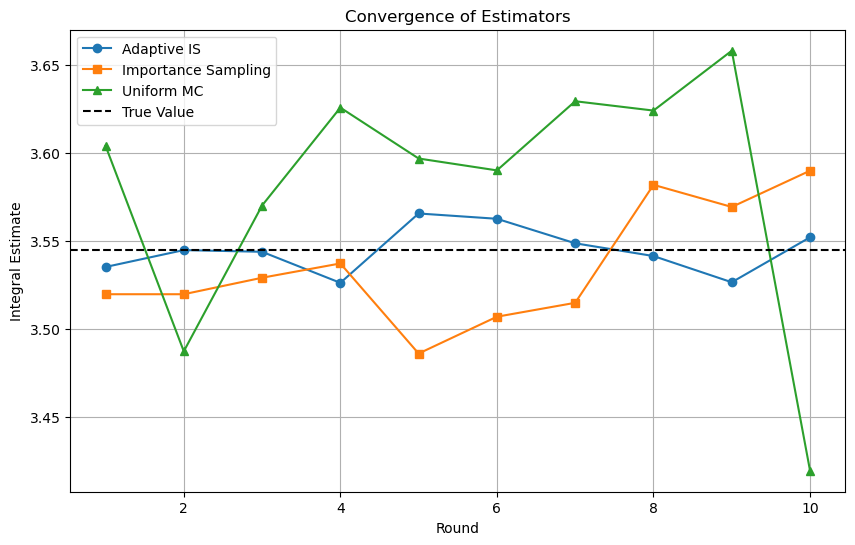

In [15]:
# Convergence tracking for uniform MC
def uniform_mc_convergence(rounds=10):
    estimates = []
    for _ in range(rounds):
        x = np.random.uniform(-5, 5, n_samples)
        estimate = 10 * np.mean(f(x))
        estimates.append(estimate)
    return estimates

# Convergence tracking for fixed importance sampling
def importance_sampling_convergence(proposal, rounds=10):
    estimates = []
    for _ in range(rounds):
        x = proposal.rvs(n_samples)
        weights = f(x) / proposal.pdf(x)
        estimate = np.mean(weights)
        estimates.append(estimate)
    return estimates

# Adaptive importance sampling convergence
def adaptive_convergence(rounds=10):
    estimates = []
    proposal = norm(loc=0, scale=1.5)
    for i in range(rounds):
        x_samples = proposal.rvs(n_samples)
        weights = f(x_samples) / proposal.pdf(x_samples)
        estimate = np.mean(weights)
        estimates.append(estimate)
        mean_new = np.average(x_samples, weights=weights)
        std_new = np.sqrt(np.average((x_samples - mean_new)**2, weights=weights))
        proposal = norm(loc=mean_new, scale=std_new)
    return estimates

def mcmc_convergence(rounds=10):
    estimates = []
    proposal_std = 1.0
    x0 = 0.0
    for _ in range(rounds):
        samples = metropolis_hastings(log_p, n_samples, proposal_std, x0)
        #samples = samples[1000:]  # burn-in
        p_vals = np.exp(log_p(samples))  # Convert log-prob back to density
        weights = f(samples) / p_vals
        estimate = np.mean(weights)
        estimates.append(estimate)
    return estimates

# Run all convergence trackers
rounds = 10
initial_proposal = norm(loc=0, scale=1.5)
adaptive_estimates = adaptive_convergence(rounds)
importance_estimates = importance_sampling_convergence(initial_proposal, rounds)
uniform_estimates = uniform_mc_convergence(rounds)
mcmc_estimates = mcmc_convergence(rounds)

# Plot
plt.figure(figsize=(10, 6))
x = range(1, rounds + 1)
plt.plot(x, adaptive_estimates, marker='o', label='Adaptive IS')
plt.plot(x, importance_estimates, marker='s', label='Importance Sampling')
plt.plot(x, uniform_estimates, marker='^', label='Uniform MC')
#plt.plot(x, mcmc_estimates, marker='D', label='MCMC (MH)')
plt.axhline(true_value, color='black', linestyle='--', label='True Value')
plt.xlabel("Round")
plt.ylabel("Integral Estimate")
plt.title("Convergence of Estimators")
plt.legend()
plt.grid(True)
plt.show()

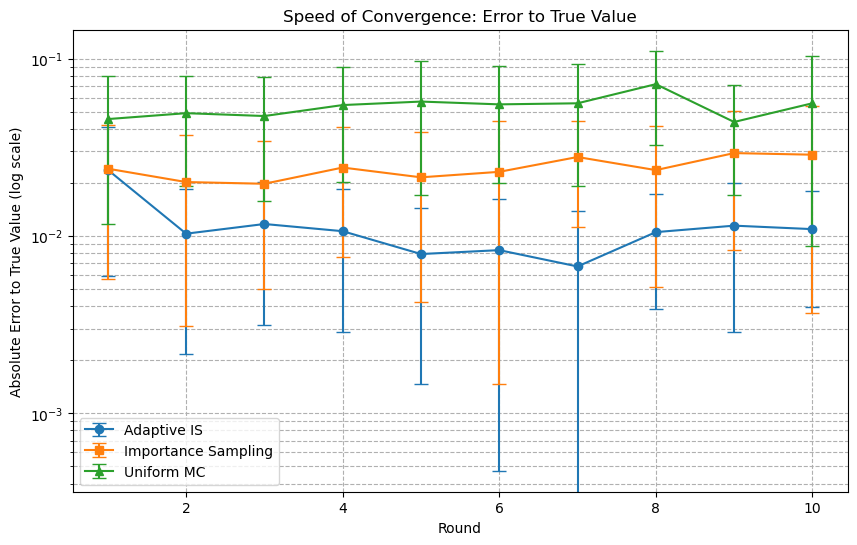

In [16]:
# Helper: compute convergence error statistics over multiple trials
def compute_convergence_errors(estimator_func, rounds=10, trials=30):
    all_errors = []
    for _ in range(trials):
        estimates = estimator_func(rounds)
        errors = [abs(est - true_value) for est in estimates]
        all_errors.append(errors)
    all_errors = np.array(all_errors)  # shape: (trials, rounds)
    mean_errors = np.mean(all_errors, axis=0)
    std_errors = np.std(all_errors, axis=0)
    return mean_errors, std_errors

# Compute error curves
adaptive_mean_err, adaptive_std_err = compute_convergence_errors(adaptive_convergence, rounds)
importance_mean_err, importance_std_err = compute_convergence_errors(
    lambda r: importance_sampling_convergence(initial_proposal, r), rounds
)
uniform_mean_err, uniform_std_err = compute_convergence_errors(uniform_mc_convergence, rounds)

# Plot speed of convergence (error to true value)
plt.figure(figsize=(10, 6))
x = np.arange(1, rounds + 1)
plt.errorbar(x, adaptive_mean_err, yerr=adaptive_std_err, label='Adaptive IS', marker='o', capsize=5)
plt.errorbar(x, importance_mean_err, yerr=importance_std_err, label='Importance Sampling', marker='s', capsize=5)
plt.errorbar(x, uniform_mean_err, yerr=uniform_std_err, label='Uniform MC', marker='^', capsize=5)
plt.yscale("log")
plt.xlabel("Round")
plt.ylabel("Absolute Error to True Value (log scale)")
plt.title("Speed of Convergence: Error to True Value")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

# WEIRD P(X): Metropolis Hastings

In [22]:
def log_p(x):
    return -x**4 + x**2  # log density

def p(x):
    return np.exp(log_p(x))  # unnormalized density

In [23]:
def f(x):
    return np.exp(-x**2) * (2 + np.sin(5 * x))

In [24]:
def metropolis_hastings(log_p, n_samples, proposal_std=1.0, x0=0.0):
    samples = []
    x = x0
    for _ in range(n_samples):
        x_proposal = np.random.normal(x, proposal_std)
        accept_prob = np.exp(log_p(x_proposal) - log_p(x))
        if np.random.rand() < accept_prob:
            x = x_proposal
        samples.append(x)
    return np.array(samples)

In [25]:
# Sample using MH
n_samples = 10000
mh_samples = metropolis_hastings(log_p, n_samples, proposal_std=1.0, x0=0.0)

# Burn-in and thinning
mh_samples = mh_samples[1000:]  # discard burn-in

# Estimate the integral: average f(x) over the samples
estimate = np.mean(f(mh_samples))

print(f"Estimated integral using MCMC: {estimate:.4f}")

Estimated integral using MCMC: 1.3092


### checking MC samples

/var/folders/bb/8wxps2kn7_q58fmzz41mytyc0000gn/T/ipykernel_35686/1952422251.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(x, f(x) / np.trapz(f(x), x), label="f(x) normalized")


Text(0.5, 1.0, 'MH Sample Density vs f(x)')

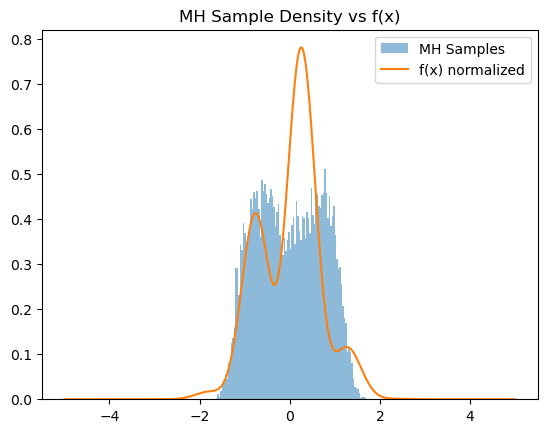

In [26]:
samples = metropolis_hastings(log_p, 20000, proposal_std=1.0, x0=0.0)[1000:]
plt.hist(samples, bins=100, density=True, alpha=0.5, label="MH Samples")
x = np.linspace(-5, 5, 500)
plt.plot(x, f(x) / np.trapz(f(x), x), label="f(x) normalized")
plt.legend(); plt.title("MH Sample Density vs f(x)")

Text(0.5, 1.0, 'Importance Weights Distribution')

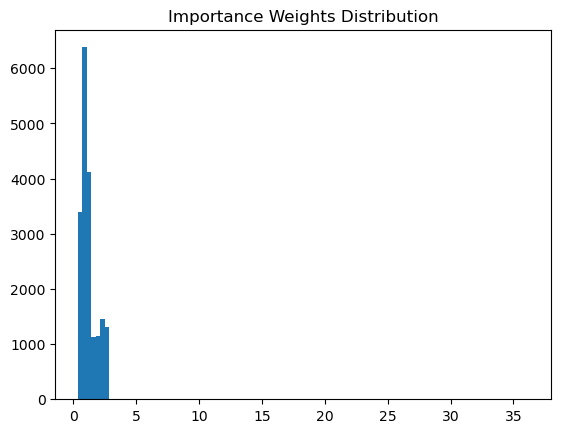

In [27]:
p_vals = np.exp(log_p(samples))
weights = f(samples) / p_vals
plt.hist(weights, bins=100)
plt.title("Importance Weights Distribution")

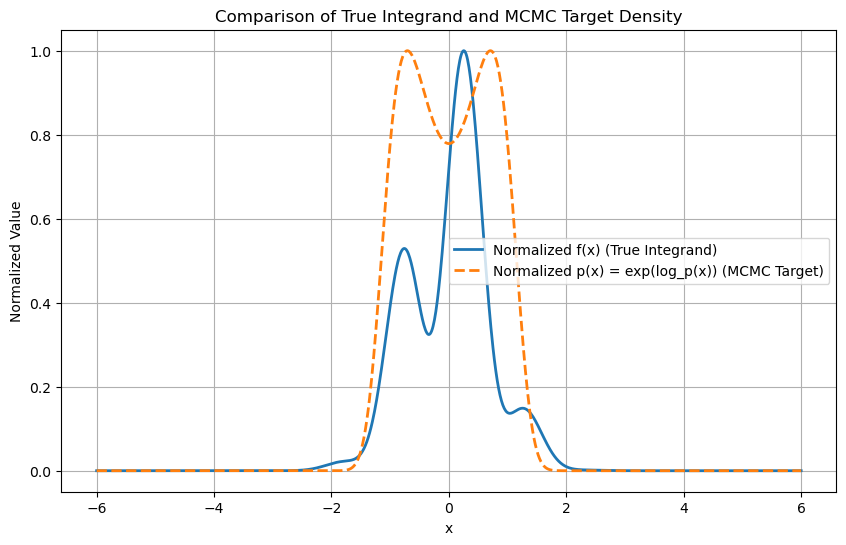

In [28]:
x_vals = np.linspace(-6, 6, 1000)
f_vals = f(x_vals)

# Compute exp(log_p(x)) to compare densities
log_p_vals = log_p(x_vals)
p_vals = np.exp(log_p_vals)

# Normalize for fair visual comparison (scale both to max=1)
f_norm = f_vals / np.max(f_vals)
p_norm = p_vals / np.max(p_vals)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, f_norm, label='Normalized f(x) (True Integrand)', linewidth=2)
plt.plot(x_vals, p_norm, label='Normalized p(x) = exp(log_p(x)) (MCMC Target)', linewidth=2, linestyle='--')
plt.title("Comparison of True Integrand and MCMC Target Density")
plt.xlabel("x")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/bb/8wxps2kn7_q58fmzz41mytyc0000gn/T/ipykernel_35686/3444223002.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(x_plot, p(x_plot) / np.trapz(p(x_plot), x_plot), label='Target p(x)', color='red')


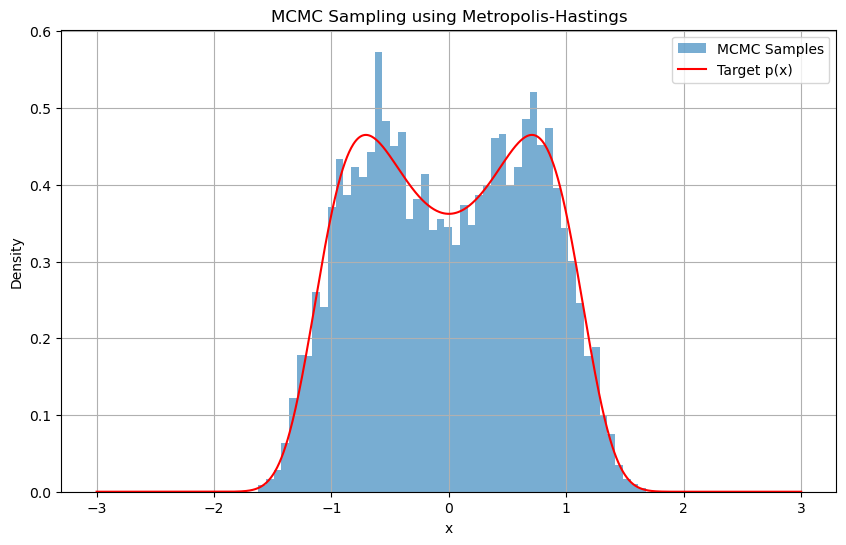

In [29]:
# Plot histogram of samples with target density
x_plot = np.linspace(-3, 3, 1000)
plt.figure(figsize=(10, 6))
plt.hist(mh_samples, bins=50, density=True, alpha=0.6, label='MCMC Samples')
plt.plot(x_plot, p(x_plot) / np.trapz(p(x_plot), x_plot), label='Target p(x)', color='red')
plt.title("MCMC Sampling using Metropolis-Hastings")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

### Convergence tracking for Metropolis-Hastings (MCMC)

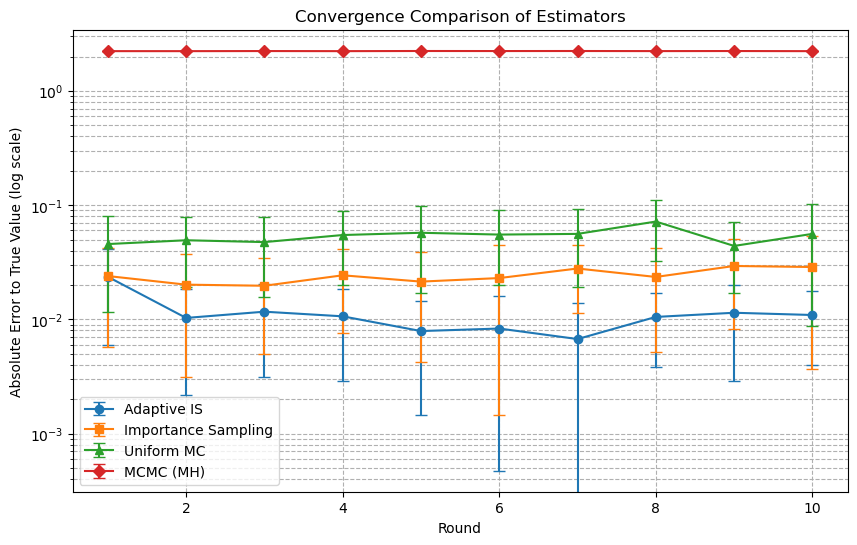

In [31]:
def mcmc_convergence(rounds=10):
    estimates = []
    proposal_std = 1.0
    x0 = 0.0
    for _ in range(rounds):
        samples = metropolis_hastings(log_p, n_samples, proposal_std, x0)
        samples = samples[1000:]  # burn-in
        estimate = np.mean(f(samples))
        estimates.append(estimate)
    return estimates

# Compute error stats for MCMC
mcmc_mean_err, mcmc_std_err = compute_convergence_errors(mcmc_convergence, rounds)

# Plot all estimators with error bars
plt.figure(figsize=(10, 6))
x = np.arange(1, rounds + 1)
plt.errorbar(x, adaptive_mean_err, yerr=adaptive_std_err, label='Adaptive IS', marker='o', capsize=4)
plt.errorbar(x, importance_mean_err, yerr=importance_std_err, label='Importance Sampling', marker='s', capsize=4)
plt.errorbar(x, uniform_mean_err, yerr=uniform_std_err, label='Uniform MC', marker='^', capsize=4)
plt.errorbar(x, mcmc_mean_err, yerr=mcmc_std_err, label='MCMC (MH)', marker='D', capsize=4)

plt.yscale("log")
plt.xlabel("Round")
plt.ylabel("Absolute Error to True Value (log scale)")
plt.title("Convergence Comparison of Estimators")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

# Bimodal

### Adaptive vs. Importance Sampling

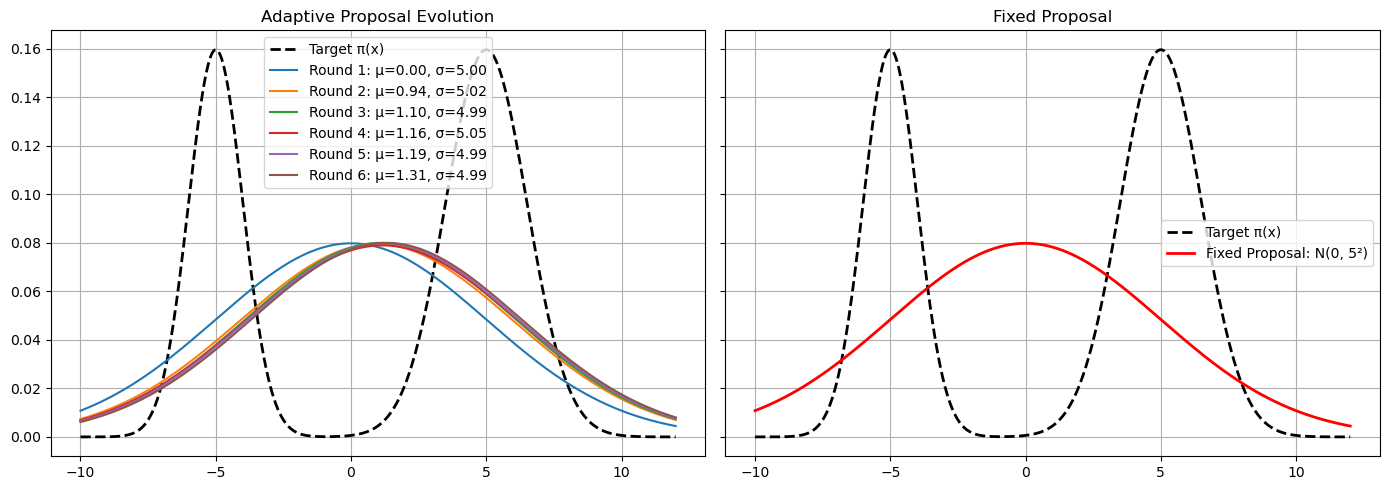

In [32]:
# Target distribution π(x)
def pi(x):
    return 0.4 * norm.pdf(x, loc=-5, scale=1) + 0.6 * norm.pdf(x, loc=5, scale=1.5)

# Parameters
x_plot = np.linspace(-10, 12, 1000)
n_samples = 1000
rounds = 6  # Fewer rounds for visualization
adaptive_params = []

# Adaptive Importance Sampling: store proposal at each round
proposal = norm(loc=0, scale=5)  # q1(x)
for i in range(rounds):
    samples = proposal.rvs(n_samples)
    weights = pi(samples) / proposal.pdf(samples)

    # Save current proposal parameters
    adaptive_params.append((proposal.mean(), proposal.std()))

    # Adapt proposal for next round
    new_mean = np.average(samples, weights=weights)
    new_std = np.sqrt(np.average((samples - new_mean)**2, weights=weights))
    proposal = norm(loc=new_mean, scale=new_std)

# Baseline proposal
baseline_proposal = norm(loc=0, scale=5)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Target distribution
target_vals = pi(x_plot)

# Plot adaptive proposals
axes[0].plot(x_plot, target_vals, 'k--', label='Target π(x)', linewidth=2)
for i, (mu, sigma) in enumerate(adaptive_params):
    q_vals = norm.pdf(x_plot, loc=mu, scale=sigma)
    axes[0].plot(x_plot, q_vals, label=f'Round {i+1}: μ={mu:.2f}, σ={sigma:.2f}')
axes[0].set_title("Adaptive Proposal Evolution")
axes[0].legend()
axes[0].grid(True)

# Plot baseline proposal
axes[1].plot(x_plot, target_vals, 'k--', label='Target π(x)', linewidth=2)
axes[1].plot(x_plot, baseline_proposal.pdf(x_plot), 'r-', label='Fixed Proposal: N(0, 5²)', linewidth=2)
axes[1].set_title("Fixed Proposal")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Error in estimated integral vs. round

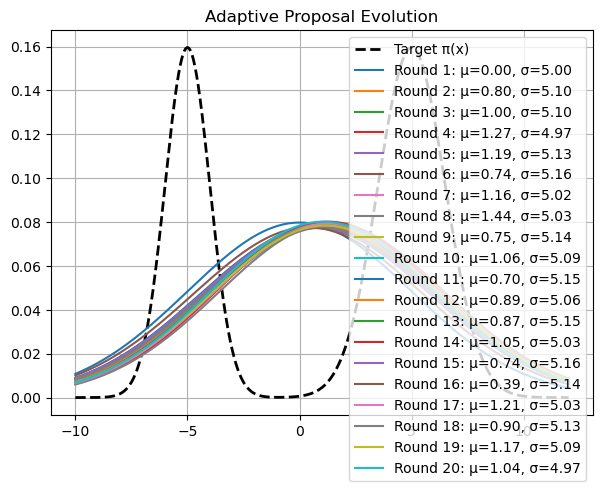

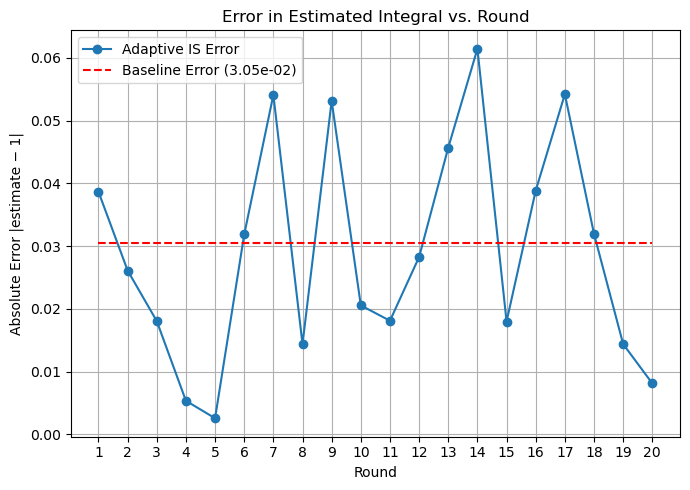

In [33]:
# Target distribution π(x)
def pi(x):
    return 0.4 * norm.pdf(x, loc=-5, scale=1) + 0.6 * norm.pdf(x, loc=5, scale=1.5)

# Parameters
x_plot     = np.linspace(-10, 12, 1000)
n_samples  = 1000
rounds     = 20  # number of adaptive rounds

# Storage for adaptive proposal parameters and errors
adaptive_params = []
errors_adaptive = []

# True value of the integral ∫π(x) dx
true_integral = 1.0

# Initialize adaptive proposal q_1(x)
proposal = norm(loc=0, scale=5)

# Adaptive IS rounds
for i in range(rounds):
    # Draw samples and compute weights
    samples = proposal.rvs(size=n_samples)
    weights = pi(samples) / proposal.pdf(samples)

    # Estimate integral and record error
    estimate = np.mean(weights)  # E_q [π(x)/q(x)]
    error    = abs(estimate - true_integral)
    errors_adaptive.append(error)

    # Save current proposal params
    adaptive_params.append((proposal.mean(), proposal.std()))

    # Adapt proposal for next round
    new_mean = np.average(samples, weights=weights)
    new_std  = np.sqrt(np.average((samples - new_mean)**2, weights=weights))
    proposal = norm(loc=new_mean, scale=new_std)

# Baseline (fixed) proposal estimate & error
baseline_proposal = norm(loc=0, scale=5)
baseline_samples  = baseline_proposal.rvs(size=n_samples)
baseline_weights  = pi(baseline_samples) / baseline_proposal.pdf(baseline_samples)
baseline_estimate = np.mean(baseline_weights)
baseline_error    = abs(baseline_estimate - true_integral)

# --- Plot 1: Adaptive Proposals vs. Target ---
fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.plot(x_plot, pi(x_plot), 'k--', label='Target π(x)', linewidth=2)
for i, (mu, sigma) in enumerate(adaptive_params):
    ax1.plot(x_plot, norm.pdf(x_plot, loc=mu, scale=sigma),
             label=f'Round {i+1}: μ={mu:.2f}, σ={sigma:.2f}')
ax1.set_title("Adaptive Proposal Evolution")
ax1.legend()
ax1.grid(True)

# --- Plot 2: Error in Estimated Integral ---
fig, ax2 = plt.subplots(figsize=(7, 5))
round_nums = np.arange(1, rounds+1)
ax2.plot(round_nums, errors_adaptive, '-o', label='Adaptive IS Error')
ax2.hlines(baseline_error, 1, rounds,
           colors='r', linestyles='--', label=f'Baseline Error ({baseline_error:.2e})')
ax2.set_xlabel("Round")
ax2.set_ylabel("Absolute Error |estimate − 1|")
ax2.set_title("Error in Estimated Integral vs. Round")
ax2.set_xticks(round_nums)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### Gaussian mixture model proposals

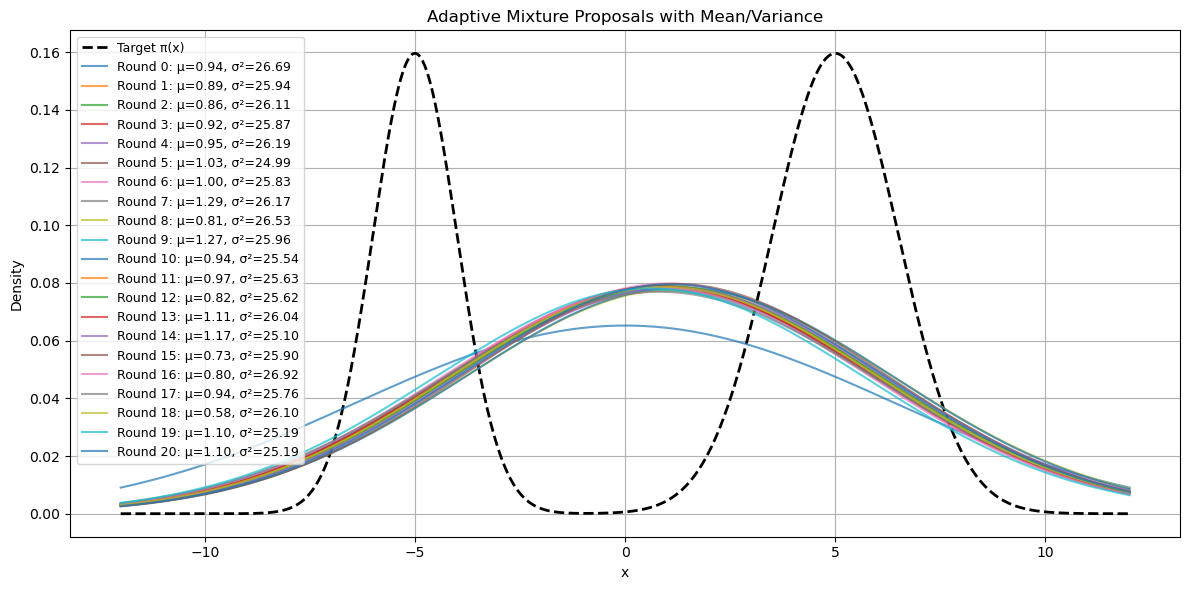

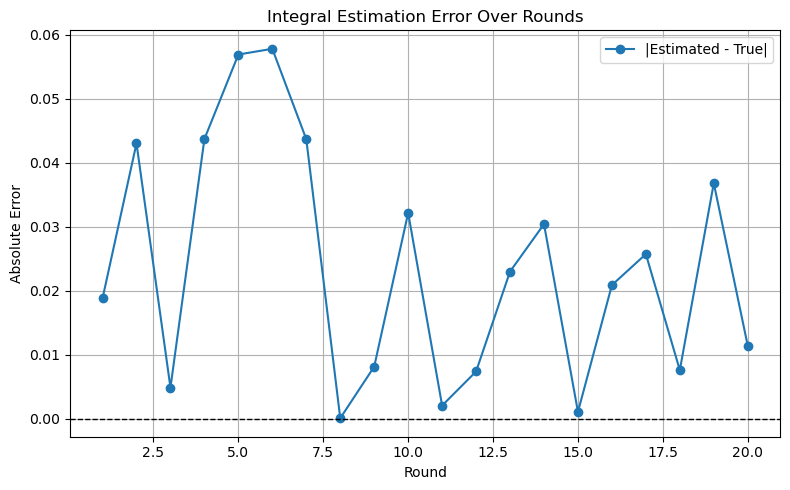

In [34]:
# --- 1. Define target π(x) ---
def pi(x):
    return 0.4 * norm.pdf(x, loc=-5, scale=1) + 0.6 * norm.pdf(x, loc=5, scale=1.5)

# True value of integral of pi(x) over ℝ should be 1 (as it's a valid PDF)
true_integral = 1.0

# --- 2. AIS parameters ---
M         = 3           # number of Gaussian components
n_samples = 1000        # samples per iteration
rounds    = 20          # adaptation rounds
x_plot    = np.linspace(-12, 12, 1000)

# --- 3. Initialize mixture (uniform weights, broad Gaussians) ---
alpha = np.ones(M) / M
mu    = np.linspace(-4, 4, M).copy()    # initial means spread out
sigma = np.ones(M) * 5.0                # broad stddev

# storage
history = {
    'alpha': [], 'mu': [], 'sigma': [],
    'mean': [], 'var': [], 'integral_est': [], 'error': []
}

# --- 4. Run adaptation ---
for t in range(rounds):
    # store current state
    history['alpha'].append(alpha.copy())
    history['mu'].append(mu.copy())
    history['sigma'].append(sigma.copy())

    # 4a. Sample from the mixture
    comp_idx = np.random.choice(M, size=n_samples, p=alpha)
    x        = np.random.randn(n_samples) * sigma[comp_idx] + mu[comp_idx]

    # 4b. Compute importance weights
    q_vals = np.zeros_like(x)
    for m in range(M):
        q_vals += alpha[m] * norm.pdf(x, loc=mu[m], scale=sigma[m])
    w = pi(x) / q_vals
    integral_est = np.mean(w)
    history['integral_est'].append(integral_est)
    history['error'].append(np.abs(integral_est - true_integral))

    # 4c. Update mixture weights
    q_comp_pdf = norm.pdf(x, loc=mu[comp_idx], scale=sigma[comp_idx])
    w_local = pi(x) / (alpha[comp_idx] * q_comp_pdf)
    total_w = np.sum(w_local)
    alpha = np.array([
        np.sum(w_local[comp_idx == m]) / total_w
        for m in range(M)
    ])

    # 4d. Update μ and σ
    for m in range(M):
        mask = (comp_idx == m)
        w_m = w_local[mask]
        x_m = x[mask]
        if w_m.size > 0:
            mu[m] = np.sum(w_m * x_m) / np.sum(w_m)
            var_m = np.sum(w_m * (x_m - mu[m])**2) / np.sum(w_m)
            sigma[m] = np.sqrt(var_m)

    # Store mixture mean and variance
    mixture_mean = np.sum(alpha * mu)
    mixture_var = np.sum(alpha * (sigma**2 + mu**2)) - mixture_mean**2
    history['mean'].append(mixture_mean)
    history['var'].append(mixture_var)

# Store final round too
history['alpha'].append(alpha.copy())
history['mu'].append(mu.copy())
history['sigma'].append(sigma.copy())
mixture_mean = np.sum(alpha * mu)
mixture_var = np.sum(alpha * (sigma**2 + mu**2)) - mixture_mean**2
history['mean'].append(mixture_mean)
history['var'].append(mixture_var)

# --- 5. Plot: Proposal Evolution ---
plt.figure(figsize=(12, 6))
plt.plot(x_plot, pi(x_plot), 'k--', lw=2, label='Target π(x)')
for t in range(rounds + 1):
    mix_pdf = sum(
        history['alpha'][t][m] * norm.pdf(x_plot,
                                          loc=history['mu'][t][m],
                                          scale=history['sigma'][t][m])
        for m in range(M)
    )
    label = f'Round {t}: μ={history["mean"][t]:.2f}, σ²={history["var"][t]:.2f}' \
            if t < len(history["mean"]) else f'Round {t}'
    plt.plot(x_plot, mix_pdf, alpha=0.7, label=label)
plt.title("Adaptive Mixture Proposals with Mean/Variance")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Plot: Error Over Rounds ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, rounds + 1), history['error'], marker='o', label='|Estimated - True|')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.title("Integral Estimation Error Over Rounds")
plt.xlabel("Round")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

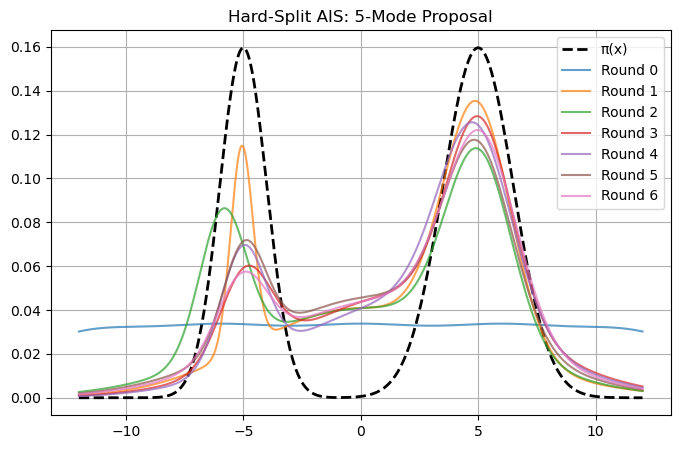

In [65]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.integrate import quad


def ais_hard_mixture(pi, domain, M, n_samples, rounds):
    """
    Hard-split AIS with M Gaussians in 1D.
    
    Args:
      pi         : function, target density π(x)
      domain     : tuple (a, b), the x-range to cover
      M          : int, number of Gaussian modes
      n_samples  : int, number of samples per round
      rounds     : int, number of adaptation rounds

    Returns:
      history: dict with keys 'alpha', 'mu', 'sigma' each a list of arrays
    """
    a, b = domain
    # 1) initialize
    alpha      = np.ones(M) / M
    mu         = np.linspace(a, b, M)                       # evenly spaced means
    init_sigma = (b - a) / (2 * (M - 1))                    # small enough
    sigma      = np.ones(M) * init_sigma

    history = {'alpha': [], 'mu': [], 'sigma': []}

    for t in range(rounds):
        # store
        history['alpha'].append(alpha.copy())
        history['mu'].append(mu.copy())
        history['sigma'].append(sigma.copy())

        # 2) sample
        comp_idx = np.random.choice(M, size=n_samples, p=alpha)
        x        = np.random.randn(n_samples) * sigma[comp_idx] + mu[comp_idx]

        # 3) weight (approx using only generating component)
        q_m_pdf = norm.pdf(x, loc=mu[comp_idx], scale=sigma[comp_idx])
        w       = pi(x) / (alpha[comp_idx] * q_m_pdf)

        # 4) update α_m
        total_w = np.sum(w)
        alpha   = np.array([
            np.sum(w[comp_idx == m]) / total_w
            for m in range(M)
        ])

        # 5) hard-split update of each (μ,σ)
        for m in range(M):
            mask = (comp_idx == m)
            w_m  = w[mask]
            x_m  = x[mask]
            if w_m.size > 0:
                mu[m]    = np.sum(w_m * x_m) / np.sum(w_m)
                var_m    = np.sum(w_m * (x_m - mu[m])**2) / np.sum(w_m)
                sigma[m] = np.sqrt(var_m)
            # if no samples: leave (mu[m],sigma[m]) unchanged

    # final store
    history['alpha'].append(alpha.copy())
    history['mu'].append(mu.copy())
    history['sigma'].append(sigma.copy())
    return history

#--- Example usage ---
def pi_target(x):
    return (0.4 * norm.pdf(x, -5, 1) +
            0.6 * norm.pdf(x,  5, 1.5))

# # Define the unnormalized function
# def pi_unnormalized(x):
#     return np.exp(-0.1 * x**2) * (np.sin(2 * x)**2 + np.cos(3 * x)**2)

# # Compute the normalization constant over a sufficiently wide interval
# Z, _ = quad(pi_unnormalized, -20, 20)

# # Define the normalized target distribution
# def pi_target(x):
#     return pi_unnormalized(x) / Z

domain     = (-12, 12)
M          = 5
n_samples  = 1000
rounds     = 6

hist = ais_hard_mixture(pi_target, domain, M, n_samples, rounds)

# --- Plot mixture evolution ---
x_plot = np.linspace(*domain, 1000)
plt.figure(figsize=(8, 5))
plt.plot(x_plot, pi_target(x_plot), 'k--', lw=2, label='π(x)')
for t in range(rounds+1):
    mix_pdf = sum(
        hist['alpha'][t][m]
        * norm.pdf(x_plot,
                   loc=hist['mu'][t][m],
                   scale=hist['sigma'][t][m])
        for m in range(M)
    )
    plt.plot(x_plot, mix_pdf, label=f'Round {t}', alpha=0.7)
plt.title(f"Hard-Split AIS: {M}-Mode Proposal")
plt.legend()
plt.grid(True)
plt.show()

### "Hard-mixure" AIS

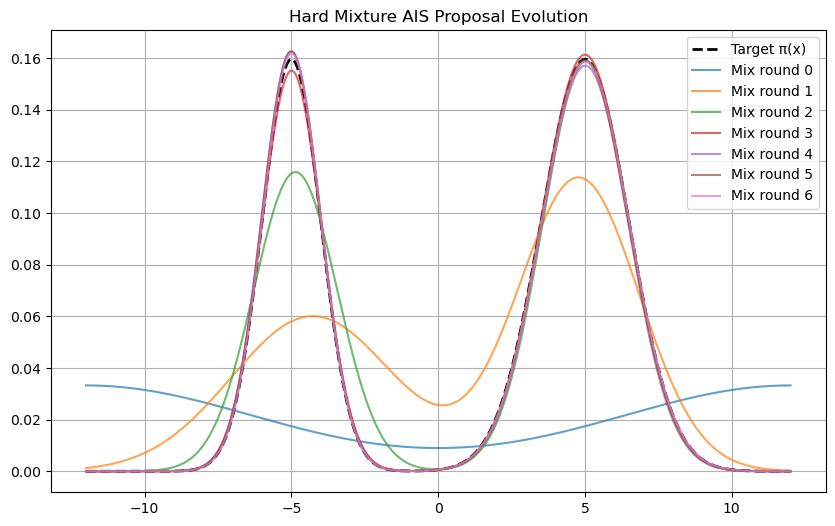

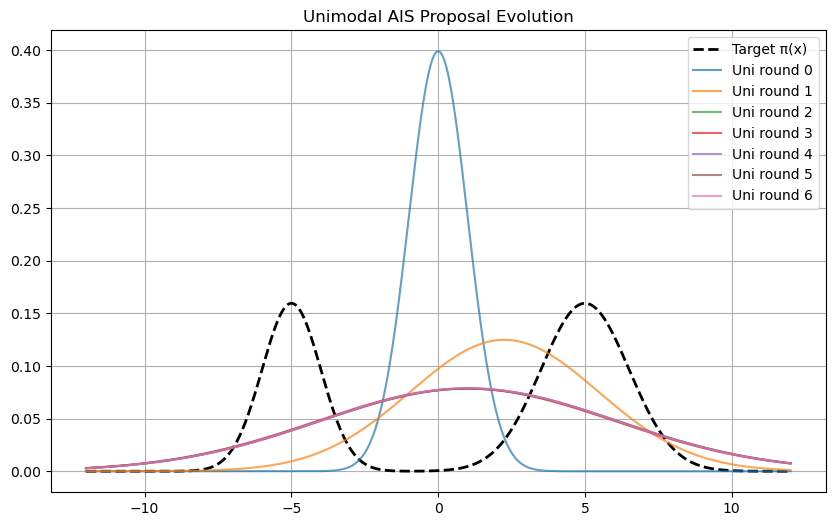

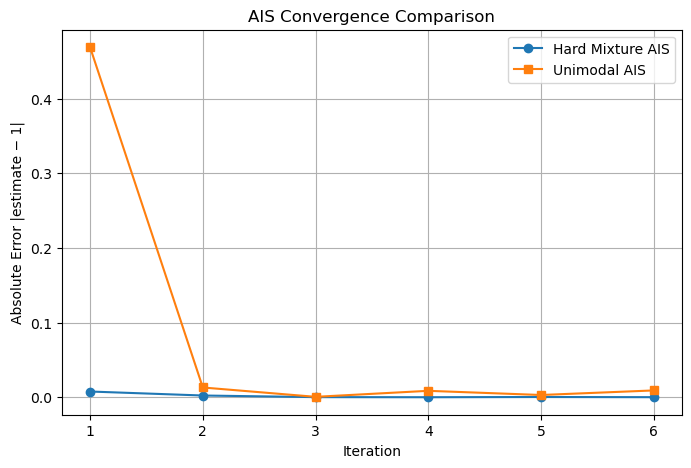

In [35]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 1. Hard-split AIS with full mixture denominator
def ais_hard_mixture(pi, domain, M, n_samples, rounds):
    a, b = domain
    alpha    = np.ones(M) / M
    mu       = np.linspace(a, b, M)
    spacing  = (b - a) / (M - 1)
    sigma    = np.ones(M) * (spacing / 4)   # initial non-overlapping

    history = {'alpha': [], 'mu': [], 'sigma': []}
    errors  = []

    for t in range(rounds):
        # record current proposal
        history['alpha'].append(alpha.copy())
        history['mu'].append(mu.copy())
        history['sigma'].append(sigma.copy())

        # sample from mixture
        comps = np.random.choice(M, size=n_samples, p=alpha)
        x     = np.random.randn(n_samples) * sigma[comps] + mu[comps]

        # full mixture density
        mix_pdf = sum(alpha[k] * norm.pdf(x, loc=mu[k], scale=sigma[k]) for k in range(M))
        w       = pi(x) / mix_pdf
        errors.append(abs(np.mean(w) - 1.0))

        # update weights
        total_w = np.sum(w)
        alpha   = np.array([np.sum(w[comps == m]) / total_w for m in range(M)])

        # hard-split update of each component
        for m in range(M):
            mask = (comps == m)
            w_m  = w[mask]
            x_m  = x[mask]
            if w_m.size > 0:
                mu[m]    = np.sum(w_m * x_m) / np.sum(w_m)
                var_m    = np.sum(w_m * (x_m - mu[m])**2) / np.sum(w_m)
                sigma[m] = np.sqrt(var_m)

    # final record
    history['alpha'].append(alpha.copy())
    history['mu'].append(mu.copy())
    history['sigma'].append(sigma.copy())

    return history, errors

# 2. Unimodal AIS baseline
def ais_unimodal(pi, mu0, sigma0, n_samples, rounds):
    mu      = mu0
    sigma   = sigma0
    history = {'mu': [mu], 'sigma': [sigma]}
    errors  = []

    for t in range(rounds):
        x     = np.random.randn(n_samples) * sigma + mu
        q_pdf = norm.pdf(x, loc=mu, scale=sigma)
        w     = pi(x) / q_pdf
        errors.append(abs(np.mean(w) - 1.0))

        # update
        mu    = np.sum(w * x) / np.sum(w)
        var   = np.sum(w * (x - mu)**2) / np.sum(w)
        sigma = np.sqrt(var)

        history['mu'].append(mu)
        history['sigma'].append(sigma)

    return history, errors

# 3. Define target and run
def pi_target(x):
    return 0.4 * norm.pdf(x, -5, 1) + 0.6 * norm.pdf(x, 5, 1.5)

domain     = (-12, 12)
M          = 2
n_samples  = 10000
rounds     = 6

hist_mix, errors_mix = ais_hard_mixture(pi_target, domain, M, n_samples, rounds)
hist_uni, errors_uni = ais_unimodal(pi_target, mu0=0.0, sigma0=1.0, n_samples=n_samples, rounds=rounds)

# 4. Plot mixture AIS proposal evolution
x_plot = np.linspace(*domain, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x_plot, pi_target(x_plot), 'k--', lw=2, label='Target π(x)')
for t in range(rounds + 1):
    mix_pdf = sum(
        hist_mix['alpha'][t][m] * norm.pdf(x_plot, loc=hist_mix['mu'][t][m], scale=hist_mix['sigma'][t][m])
        for m in range(M)
    )
    plt.plot(x_plot, mix_pdf, alpha=0.7, label=f'Mix round {t}')
plt.title('Hard Mixture AIS Proposal Evolution')
plt.legend()
plt.grid(True)
plt.show()

# 5. Plot unimodal AIS proposal evolution
plt.figure(figsize=(10, 6))
plt.plot(x_plot, pi_target(x_plot), 'k--', lw=2, label='Target π(x)')
for t in range(rounds + 1):
    uni_pdf = norm.pdf(x_plot, loc=hist_uni['mu'][t], scale=hist_uni['sigma'][t])
    plt.plot(x_plot, uni_pdf, alpha=0.7, label=f'Uni round {t}')
plt.title('Unimodal AIS Proposal Evolution')
plt.legend()
plt.grid(True)
plt.show()

# 6. Plot convergence comparison
iters = np.arange(1, rounds + 1)
plt.figure(figsize=(8, 5))
plt.plot(iters, errors_mix, '-o', label='Hard Mixture AIS')
plt.plot(iters, errors_uni, '-s', label='Unimodal AIS')
plt.xlabel('Iteration')
plt.ylabel('Absolute Error |estimate − 1|')
plt.title('AIS Convergence Comparison')
plt.xticks(iters)
plt.legend()
plt.grid(True)
plt.show()

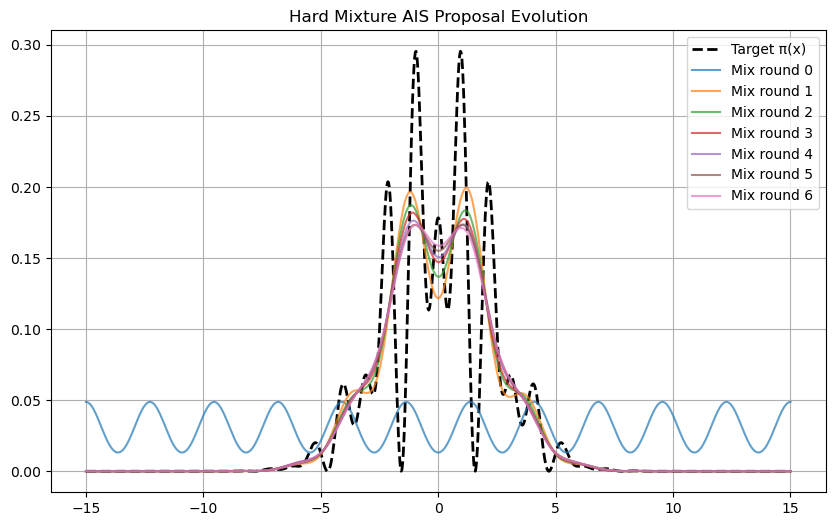

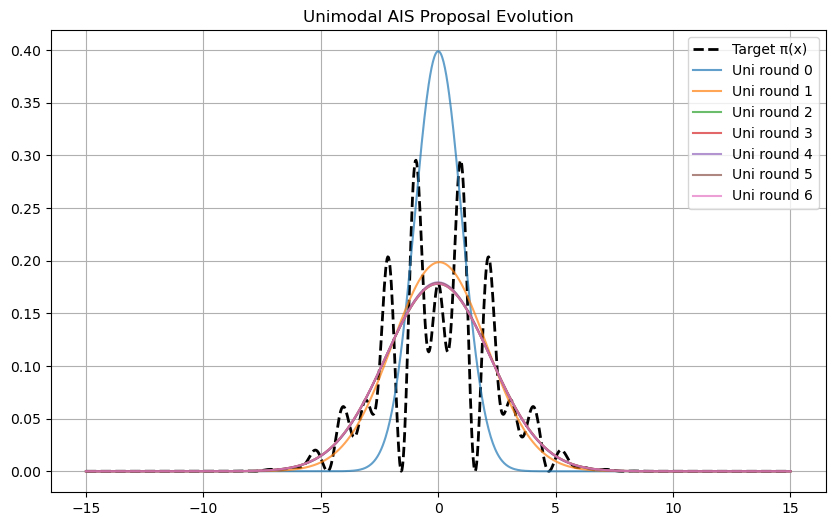

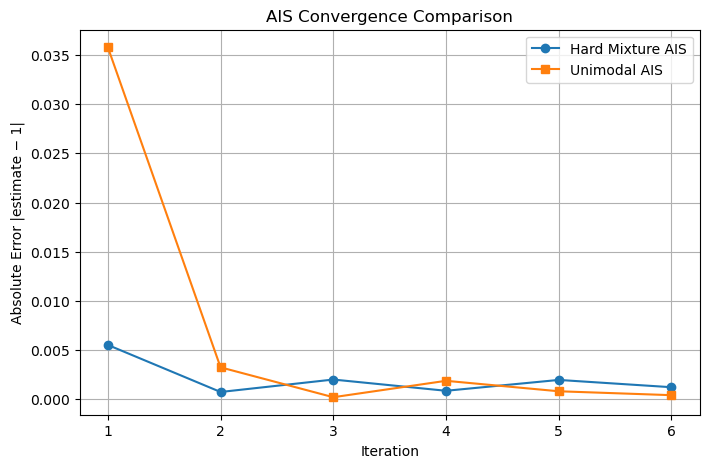

In [47]:
from scipy.integrate import quad

# Define the unnormalized function
def pi_unnormalized(x):
    return np.exp(-0.1 * x**2) * (np.sin(2 * x)**2 + np.cos(3 * x)**2)

# Compute the normalization constant over a sufficiently wide interval
Z, _ = quad(pi_unnormalized, -20, 20)

# Define the normalized target distribution
def pi_target(x):
    return pi_unnormalized(x) / Z


domain     = (-15, 15)
M          = 12
n_samples  = 100000
rounds     = 6

hist_mix, errors_mix = ais_hard_mixture(pi_target, domain, M, n_samples, rounds)
hist_uni, errors_uni = ais_unimodal(pi_target, mu0=0.0, sigma0=1.0, n_samples=n_samples, rounds=rounds)

# 4. Plot mixture AIS proposal evolution
x_plot = np.linspace(*domain, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x_plot, pi_target(x_plot), 'k--', lw=2, label='Target π(x)')
for t in range(rounds + 1):
    mix_pdf = sum(
        hist_mix['alpha'][t][m] * norm.pdf(x_plot, loc=hist_mix['mu'][t][m], scale=hist_mix['sigma'][t][m])
        for m in range(M)
    )
    plt.plot(x_plot, mix_pdf, alpha=0.7, label=f'Mix round {t}')
plt.title('Hard Mixture AIS Proposal Evolution')
plt.legend()
plt.grid(True)
plt.show()

# 5. Plot unimodal AIS proposal evolution
plt.figure(figsize=(10, 6))
plt.plot(x_plot, pi_target(x_plot), 'k--', lw=2, label='Target π(x)')
for t in range(rounds + 1):
    uni_pdf = norm.pdf(x_plot, loc=hist_uni['mu'][t], scale=hist_uni['sigma'][t])
    plt.plot(x_plot, uni_pdf, alpha=0.7, label=f'Uni round {t}')
plt.title('Unimodal AIS Proposal Evolution')
plt.legend()
plt.grid(True)
plt.show()

# 6. Plot convergence comparison
iters = np.arange(1, rounds + 1)
plt.figure(figsize=(8, 5))
plt.plot(iters, errors_mix, '-o', label='Hard Mixture AIS')
plt.plot(iters, errors_uni, '-s', label='Unimodal AIS')
plt.xlabel('Iteration')
plt.ylabel('Absolute Error |estimate − 1|')
plt.title('AIS Convergence Comparison')
plt.xticks(iters)
plt.legend()
plt.grid(True)
plt.show()